In [1]:
from numpy.random import choice
from pgmpy.readwrite import BIFReader
from queue import Queue
from functools import reduce

In [2]:
data_path = "data/cancer.bif"
reader = BIFReader(data_path)

In [3]:
model = reader.get_model()
variables = reader.get_variables()
edges = reader.get_edges()
states = reader.get_states()

In [4]:
dict_parents, dict_children = {}, {}

for variable in variables:
    dict_parents[variable] = []
    dict_children[variable] = []

for [parent, child] in edges:
    dict_parents[child].append(parent)
    dict_children[parent].append(child)


print("Parents:")
print(dict_parents)
print("Children:")
print(dict_children)

Parents:
{'Pollution': [], 'Smoker': [], 'Cancer': ['Pollution', 'Smoker'], 'Xray': ['Cancer'], 'Dyspnoea': ['Cancer']}
Children:
{'Pollution': ['Cancer'], 'Smoker': ['Cancer'], 'Cancer': ['Xray', 'Dyspnoea'], 'Xray': [], 'Dyspnoea': []}


In [5]:
for var in variables:
    print(model.get_cpds(var))

+-----------------+-----+
| Pollution(low)  | 0.9 |
+-----------------+-----+
| Pollution(high) | 0.1 |
+-----------------+-----+
+---------------+-----+
| Smoker(True)  | 0.3 |
+---------------+-----+
| Smoker(False) | 0.7 |
+---------------+-----+
+---------------+----------------+----------------+-----------------+-----------------+
| Pollution     | Pollution(low) | Pollution(low) | Pollution(high) | Pollution(high) |
+---------------+----------------+----------------+-----------------+-----------------+
| Smoker        | Smoker(True)   | Smoker(False)  | Smoker(True)    | Smoker(False)   |
+---------------+----------------+----------------+-----------------+-----------------+
| Cancer(True)  | 0.03           | 0.001          | 0.05            | 0.02            |
+---------------+----------------+----------------+-----------------+-----------------+
| Cancer(False) | 0.97           | 0.999          | 0.95            | 0.98            |
+---------------+----------------+------------

In [6]:
def generate_combinations(queries, cur_list):
    if len(cur_list) == 0:
        return queries
    value, rest_list = cur_list[0], cur_list[1:]
    new_queries = []
    for state in states[value]:
        for query in queries:
            cur_query = query.copy()
            cur_query[value] = state
            new_queries.append(cur_query)

    return generate_combinations(new_queries, rest_list)

def get_dict(cur_dict, node):
    keys = [node] + dict_parents[node]
    res = dict((k, cur_dict[k]) for k in keys)
    return res

def get_prob(cur_dict):
    q = Queue()
    visited_dict = {}
    for root_node in model.get_roots():
        q.put(root_node)
        visited_dict[root_node] = model.get_cpds(root_node).to_factor().get_value(**get_dict(cur_dict, root_node))
    while not q.empty():
        cur_node = q.get()
        for child in dict_children[cur_node]:
            if child not in visited_dict:
                visited_dict[child] = model.get_cpds(child).to_factor().get_value(**get_dict(cur_dict, child))
                q.put(child)
    return reduce(lambda x, y: x*y, visited_dict.values())

In [7]:
example_dict = {'Pollution': 'low',
                'Smoker': 'False',
                'Xray': 'negative',
                'Dyspnoea': 'False'
                }


def query_1(dict_data):
    all_values = [dict_data]
    missing_variables = list(set(variables) - set(dict_data.keys()))
    all_values = generate_combinations(all_values, missing_variables)
    full_prob = 0
    for cur_values in all_values:
        cur_prob = get_prob(cur_values)
        full_prob += cur_prob
    return full_prob

query_1(example_dict)

0.35246925

In [8]:
def query_2(dict_data, samples=10000):
    all_values = [{}]
    all_values = generate_combinations(all_values, variables)

    query_values = [dict_data]
    missing_variables = list(set(variables) - set(dict_data.keys()))
    query_values = generate_combinations(query_values, missing_variables)

    full_probs = []
    dict_cnt = {}
    for cur_values in all_values:
        dict_cnt[frozenset(cur_values.items())] = 0
        cur_prob = get_prob(cur_values)
        full_probs.append(cur_prob)

    for _ in range(samples):
        dict_cnt[frozenset(choice(all_values, p=full_probs).items())] += 1

    cnt_sum = 0
    for key in query_values:
        cnt_sum += dict_cnt[frozenset(key.items())]

    return cnt_sum/samples

query_2(example_dict)

0.3526

In [9]:
def generate_plot_data(cur_dict):
    nums = [pow(2, i) for i in range(5, 20)]
    answers_1, answers_2 = [], []
    for cur_num in nums:
        answers_1.append(query_1(cur_dict))
        answers_2.append(query_2(cur_dict, samples=cur_num))

    return nums, answers_1, answers_2

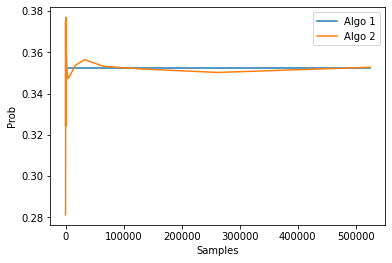

In [10]:
from matplotlib import pyplot as plt

def draw_plot(x, y1, y2):
    fig, ax = plt.subplots()
    plt.plot(x, y1, label='Algo 1')
    plt.plot(x, y2, label='Algo 2')
    ax.set_xlabel("Samples")
    ax.set_ylabel("Prob")
    plt.legend()

x, y1, y2 = generate_plot_data(example_dict)
draw_plot(x, y1, y2)

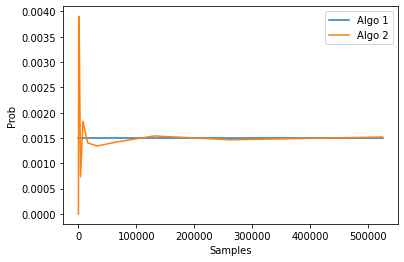

In [11]:
example_dict2 = {'Pollution': 'high',
                 'Smoker': 'True',
                 'Cancer': 'True'
                }

x, y1, y2 = generate_plot_data(example_dict2)
draw_plot(x, y1, y2)